## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


#### Part I - Probability

To get started, let's import our libraries.

In [56]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [57]:
df=pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [58]:
print("Number of rows: ",df.shape[0])
print("Number of columns: ",df.shape[1])

Number of rows:  294478
Number of columns:  5


c. The number of unique users in the dataset.

In [59]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [60]:
df.query('converted==1').shape[0]/df.shape[0]

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [61]:
df.query('landing_page=="new_page" & group!="treatment"').shape[0]+df.query('landing_page!="new_page" & group=="treatment"').shape[0]

3893

f. Do any of the rows have missing values?

In [62]:
df.isnull().any()

user_id         False
timestamp       False
group           False
landing_page    False
converted       False
dtype: bool

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [63]:
df.drop(df[(df['landing_page']=="new_page") & (df['group']!="treatment")].index,inplace=True)
df.drop(df[(df['landing_page']=="old_page") & (df['group']!="control")].index,inplace=True)
df2=df

In [64]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [65]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [66]:
df2.user_id[df2.user_id.duplicated()]

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [67]:
df[df['user_id']==773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [68]:
df2.drop(1899,inplace=True)

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [69]:
df2.query('converted==1').shape[0]/df2.shape[0]

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [70]:
df2.query('converted==1 & group=="control"').shape[0]/df2.query('group=="control"').shape[0]

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [71]:
df2.query('converted==1 & group=="treatment"').shape[0]/df2.query('group=="treatment"').shape[0]

0.11880806551510564

d. What is the probability that an individual received the new page?

In [72]:
df.query('landing_page=="new_page"').shape[0]/df.shape[0]

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**NO.** __By using probability we cant conclude that new treatment page leads to more conversions as we are dealing with a sample of population. We have to conduct hypothesis tests which help us to infer  so as to conclude anything about population.__

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

__Null Hypothesis:__ **$p_{new}$** <= **$p_{old}$**
<br />
__Alternative Hypothesis:__ **$p_{new}$** > **$p_{old}$**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [73]:
p_new = df2.converted.mean()
print(p_new)

0.11959708724499628


b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [74]:
p_old = df2.converted.mean()
print(p_old)

0.11959708724499628


c. What is $n_{new}$, the number of individuals in the treatment group?

In [75]:
n_new=df.query('group=="treatment"').shape[0]
print(n_new)

145310


d. What is $n_{old}$, the number of individuals in the control group?

In [76]:
n_old=df.query('group=="control"').shape[0]
print(n_old)

145274


e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [77]:

new_page_converted = np.random.choice([0, 1], size = n_new, p = [p_new, 1 - p_new])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [78]:
old_page_converted = np.random.choice([0, 1], size = n_old, p = [p_old, 1 - p_old])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [79]:
p_diff = new_page_converted.mean() - old_page_converted.mean()
print(p_diff)

-0.0011541972195925343


h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [80]:
# Create sampling distribution for (p_new-p_old) simulated values with boostrapping
p_diffs = []
for i in range(10000):
    p_new1 = np.random.choice([1, 0],n_new,replace = True,p = [p_new, 1-p_new])
    p_old1 = np.random.choice([1, 0],n_old,replace = True,p = [p_old, 1-p_old])
    p_new2 = p_new1.mean()
    p_old2 = p_old1.mean()
    p_diffs.append(p_new2-p_old2)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

Text(0, 0.5, 'Count')

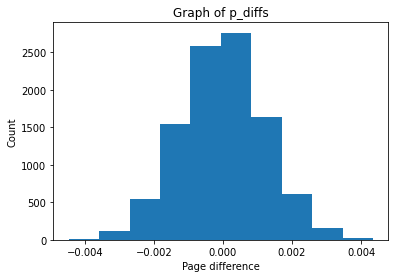

In [81]:
p_diffs=np.array(p_diffs)
plt.hist(p_diffs)
plt.title('Graph of p_diffs')#title of the plot
plt.xlabel('Page difference') # x-label of plot
plt.ylabel('Count') # y-label of plot

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [82]:
p_diffs = np.array(p_diffs)
act_diff = df2.query('group == "treatment"').converted.mean() - df2.query('group == "control"').converted.mean()
(p_diffs>act_diff).mean()

0.9035

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

__the p-value which is the probability of obtaining our statistic as extreme value assuming that the null hypothesis is true.__

__Having a large p-value signifies that there is no statistical evidence to reject the null hypothesis.smaller p-value means that there is stronger evidence in favor of the alternative hypothesis.__

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [83]:
import statsmodels.api as sm

convert_old =df2.query('converted==1 and landing_page=="old_page"').shape[0]
convert_new =df2.query('converted==1 and landing_page=="new_page"').shape[0] 
n_old = df2.query('landing_page=="old_page"').shape[0] 
n_new = df2.query('landing_page=="new_page"').shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [84]:
#Calculating p-value and z score
z_score, p_value = sm.stats.proportions_ztest([convert_old,convert_new], [n_old, n_new],alternative='smaller') 

#printing z-score and p-value
print(z_score,p_value)

1.3109241984234394 0.9050583127590245


We check the Z critical value at 95% confidence interval

In [85]:
from scipy.stats import norm
norm.ppf(1-(0.05/2))

1.959963984540054

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**YES.** Results above deduced a z_score of 1.31. Since this value does not exceed the critical value at 95% confidence interval (1.96); there is no statistical evidence to reject the null hypothesis. Furthermore, p-value obtained is similar to the result obtained from our previous findings in j. and k. which also fails to reject the null hypothesis as it provides evidence of a higher probability of the null hypothesis

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

We should use **Logistic Regression**  it is used to describe data and to explain the relationship between one dependent binary variable and one or more nominal, ordinal, interval or ratio-level independent variables.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [86]:
df2['intercept'] = 1
df2[['ab_page1', 'ab_page']] = pd.get_dummies(df2['group'])
df2 = df2.drop('ab_page1', axis = 1)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [87]:
import statsmodels.api as sm
lm_1= sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results_lm1= lm_1.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [88]:
results_lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 12 May 2020   Pseudo R-squ.:               8.077e-06
Time:                        01:53:08   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br>

**The p-value correlated with ab_page is 0.19 which is lower than the p-value in Part II which was around 0.9. The reason for this difference may be because  as the null and alternative hypothesis different.**

<br />

__In Part II:__
<br />
 Null Hypothesis: **$p_{new}$** <= **$p_{old}$**
<br />
 Alternative Hypothesis: **$p_{new}$** > **$p_{old}$**
<br />
<br />
__In Logistic Regression:__
<br />
 Null Hypothesis: **$p_{new}$** == **$p_{old}$**
<br />
 Alternative Hypothesis: **$p_{new}$** != **$p_{old}$**


f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**It is really good idea to add the additional terms as they also be correlated to the conversion of the users. The disadvantage is that our additional terms may influence the result in some direction which may rise correlation errors.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [89]:
# import countries.csv to a dataframe
countries = pd.read_csv('countries.csv')
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [90]:
#perform inner join to both of the dataframes because user_id is the foreign key in that table.
new_df= countries.set_index('user_id').join(df2.set_index('user_id'), how = 'inner')
new_df.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [91]:
new_df[['US', 'UK']] = pd.get_dummies(new_df['country'])[['US', "UK"]]
new_df.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,US,UK
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1


In [92]:
lm_2 = sm.Logit(new_df['converted'],new_df[['intercept', 'UK', 'US']])
results_lm2 = lm_2.fit()
results_lm2.summary()


Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Tue, 12 May 2020   Pseudo R-squ.:               1.521e-05
Time:                        01:53:11   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
US             0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

**According to the summary the p-value for both countries yields a value larger than 0.05; therfore, they are not statistically significant in the conversion of the users.**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [93]:
lm_3= sm.Logit(new_df['converted'], new_df[['intercept', 'UK', 'US', 'ab_page']])
results_lm3= lm_3.fit()
results_lm3.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Tue, 12 May 2020   Pseudo R-squ.:               2.323e-05
Time:                        01:53:14   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
==============================================================================
"""

**According to results above, even after adding there does not seem to be any statistical evidence to indicate an impact on the conversion since p-values were all exceeding 0.05.**

<a id='conclusions'></a>
## Conclusion:
None of the variables have significant p-values. Therefore, we will fail to reject the null and conclude that there is not sufficient evidence to suggest that there is an interaction between country and page received that will predict whether a user converts or not.

In the larger picture, based on the available information, we do not have sufficient evidence to suggest that the new page results in more conversions than the old page.